In [1]:
import json
import pathlib
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["axes.grid"] = True

FILES = [
    "out/config_Zendure2400_noBattery.json",
    "out/config_Zendure2400_2880kwh.json",
    "out/config_Zendure2400_5760kwh.json",
    "out/config_Zendure2400_8640kwh.json",
    "out/config_Zendure2400_11520kwh.json",
    "out/config_Zendure2400_14400kwh.json",
]

def load_json(path):
    with open(path, "r") as f:
        return json.load(f)
    
def battery_size_from_config(data) -> int:
    # total capacity across phases (Wh)
    return sum(data["configuration"]["battery"]["capacity_Wh_per_phase"])

SEASON_ORDER = ["spring", "summer", "autumn", "winter"]
EXPORT_FIGURES = True
SEASON_FIG_DIR = pathlib.Path("out/season")
SEASON_FIG_DIR.mkdir(parents=True, exist_ok=True)

FIG_EXPORT_COUNTER = 0

def export_current_figure(out_dir):
    global FIG_EXPORT_COUNTER
    if not EXPORT_FIGURES:
        return

    title = plt.gca().get_title() or "figure"
    slug = re.sub(r"[^a-z0-9]+", "_", title.lower()).strip("_")
    FIG_EXPORT_COUNTER += 1

    out_path = out_dir / f"{FIG_EXPORT_COUNTER:02d}_{slug}.png"
    plt.savefig(out_path, dpi=200)
    print(f"Saved figure: {out_path}")


Extract seasonal total_gain_chf

In [2]:
rows = []

for file in FILES:
    scenario = pathlib.Path(file).stem.replace("config_", "")
    data = load_json(file)

    battery_size_wh = battery_size_from_config(data)

    seasons = data.get("seasons")
    if seasons is None:
        print(f"⚠️ No seasons section in {scenario}, skipping")
        continue

    for season, values in seasons.items():
        flows = values.get("energy_flows", {})
        with_batt = flows.get("with_battery", {})
        without_batt = flows.get("without_battery", {})
        saturation = values.get("battery_saturation", {})
        energy_undersize = values.get("battery_energy_undersize_days", {})
        evening_undersize = values.get("battery_evening_undersize_days", {})
        pu = values.get("power_usage", {})
        charging_at_max = pu.get("charging", {}).get("at_max", {}).get("samples_percent", 0.0)
        discharging_at_max = pu.get("discharging", {}).get("at_max", {}).get("samples_percent", 0.0)
        idle_could_charge_at_max = pu.get("idle", {}).get("could_charge", {}).get("at_max", {}).get("samples_percent", 0.0)
        idle_could_discharge_at_max = pu.get("idle", {}).get("could_discharge", {}).get("at_max", {}).get("samples_percent", 0.0)
        
        idle = pu.get("idle", {})
        could_charge_at_max = (idle.get("could_charge", {}).get("at_max", {}).get("samples_percent", 0.0))
        no_opportunity = idle.get("no_opportunity", {}).get("samples_percent", 0.0)

        charging_not_at_max = pu.get("charging", {}).get("not_at_max", {}).get("samples_percent", 0.0)
        discharging_not_at_max = pu.get("discharging", {}).get("not_at_max", {}).get("samples_percent", 0.0)

        idle_could_charge_not_at_max = (
            idle.get("could_charge", {})
                .get("not_at_max", {})
                .get("samples_percent", 0.0)
        )

        idle_could_discharge_not_at_max = (
            idle.get("could_discharge", {})
                .get("not_at_max", {})
                .get("samples_percent", 0.0)
        )

        idle_no_opportunity = idle.get("no_opportunity", {}).get("samples_percent", 0.0)

        rows.append({
            "season": season.lower(),
            "scenario": scenario,
            "battery_size_wh": battery_size_wh,

            "total_gain_chf": values.get("total_gain_chf", 0.0),

            "grid_consumed_with_kwh": with_batt.get("grid_consumed_kwh", 0.0),
            "grid_injected_with_kwh": with_batt.get("grid_injected_kwh", 0.0),

            "grid_consumed_without_kwh": without_batt.get("grid_consumed_kwh", 0.0),
            "grid_injected_without_kwh": without_batt.get("grid_injected_kwh", 0.0),
            
            "battery_charged_kwh": with_batt.get("battery_charged_kwh", 0.0),
            "battery_discharged_kwh": with_batt.get("battery_discharged_kwh", 0.0),   

            "avg_full_pct": saturation.get("average_full_share_percent", 0.0),
            "avg_empty_pct": saturation.get("average_empty_share_percent", 0.0),

            "energy_undersize_pct": energy_undersize.get("percent", 0.0),
            "evening_undersize_pct": evening_undersize.get("percent", 0.0),

            "power_at_max_pct": charging_at_max + discharging_at_max + idle_could_charge_at_max + idle_could_discharge_at_max,

            "charging_at_max_pct": charging_at_max,
            "discharging_at_max_pct": discharging_at_max,
            "idle_could_charge_at_max_pct": idle_could_charge_at_max,
            "idle_could_discharge_at_max_pct": idle_could_discharge_at_max,
            "active_power_at_max_pct": charging_at_max + discharging_at_max,
            "idle_power_limited_pct" : idle_could_discharge_at_max + idle_could_charge_at_max,
            "idle_could_charge_at_max_pct": could_charge_at_max,
            "charging_not_at_max_pct": charging_not_at_max,
            "discharging_not_at_max_pct": discharging_not_at_max,
            "idle_could_charge_not_at_max_pct": idle_could_charge_not_at_max,
            "idle_could_discharge_not_at_max_pct": idle_could_discharge_not_at_max,
            "idle_no_opportunity_pct": idle_no_opportunity,
        })

df_energy = pd.DataFrame(rows)

df_energy["season"] = pd.Categorical(
    df_energy["season"],
    categories=SEASON_ORDER,
    ordered=True
)

df_energy = df_energy.sort_values("battery_size_wh")

scenario_order = (
    df_energy[["scenario", "battery_size_wh"]]
    .drop_duplicates()
    .sort_values("battery_size_wh")["scenario"]
    .tolist()
)

Plot – Seasonal Total Gain (CHF)

Saved figure: out/season/01_seasonal_net_financial_gain_vs_no_battery.png


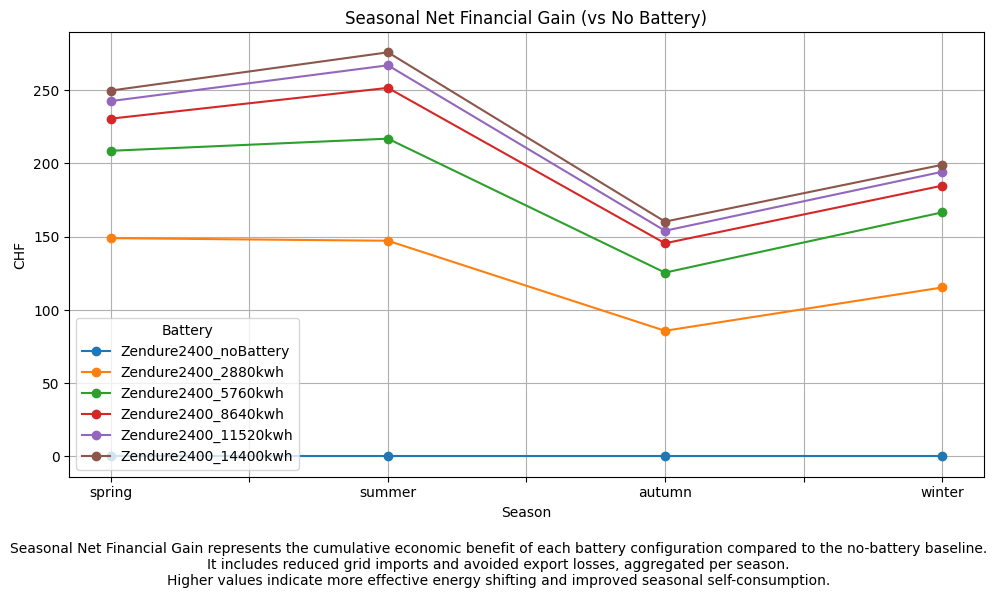

In [3]:

pivot = df_energy.pivot(
    index="season",
    columns="scenario",
    values="total_gain_chf"
)

pivot = pivot.reindex(SEASON_ORDER)
pivot = pivot[scenario_order]

pivot.plot(marker="o")

plt.title("Seasonal Net Financial Gain (vs No Battery)")
plt.xlabel("Season")
plt.ylabel("CHF")
plt.legend(title="Battery")
plt.tight_layout(rect=[0, 0.10, 1, 1])
plt.figtext(
    0.5, 0.02,
    "Seasonal Net Financial Gain represents the cumulative economic benefit "
    "of each battery configuration compared to the no-battery baseline.\n"
    "It includes reduced grid imports and avoided export losses, aggregated per season.\n"
    "Higher values indicate more effective energy shifting and improved seasonal self-consumption.",
    ha="center",
    fontsize=10,
    wrap=True
)
export_current_figure(SEASON_FIG_DIR)
plt.show()



Graph 1 – Seasonal Grid Consumed (with battery)

Saved figure: out/season/02_seasonal_grid_import_reduction_vs_no_battery.png


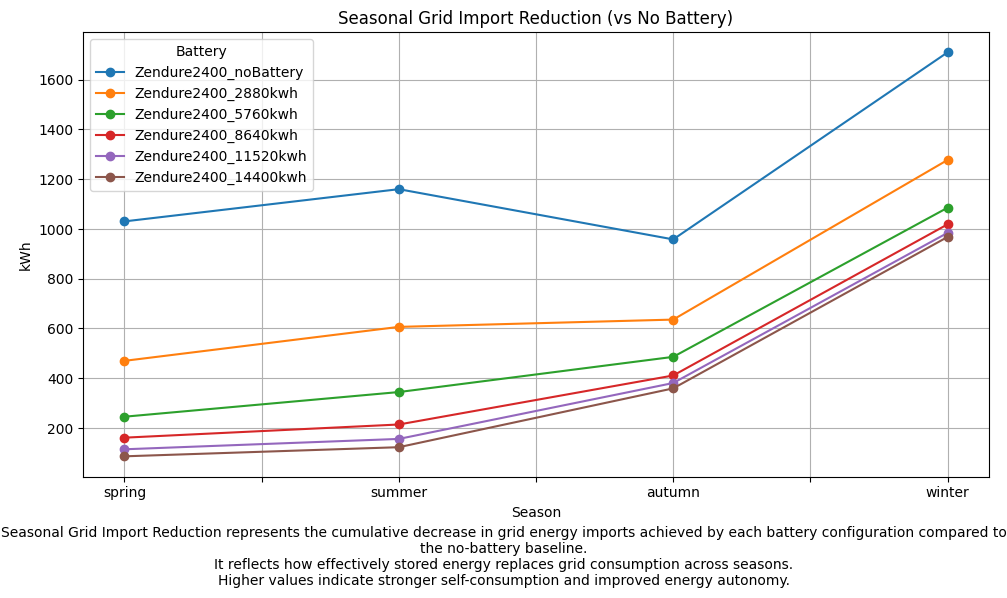

In [4]:
pivot = df_energy.pivot(
    index="season",
    columns="scenario",
    values="grid_consumed_with_kwh"
)

pivot = pivot[scenario_order]

pivot.plot(marker="o")
plt.title("Seasonal Grid Import Reduction (vs No Battery)")
plt.xlabel("Season")
plt.ylabel("kWh")
plt.legend(title="Battery")
plt.tight_layout(rect=[0, 0.10, 1, 1])
plt.figtext(
    0.5, 0.02,
    "Seasonal Grid Import Reduction represents the cumulative decrease in grid energy "
    "imports achieved by each battery configuration compared to the no-battery baseline.\n"
    "It reflects how effectively stored energy replaces grid consumption across seasons.\n"
    "Higher values indicate stronger self-consumption and improved energy autonomy.",
    ha="center",
    fontsize=10,
    wrap=True
)
export_current_figure(SEASON_FIG_DIR)
plt.show()


Graph 2 – Seasonal Grid Injected (with battery)

Saved figure: out/season/03_seasonal_grid_export_reduction_vs_no_battery.png


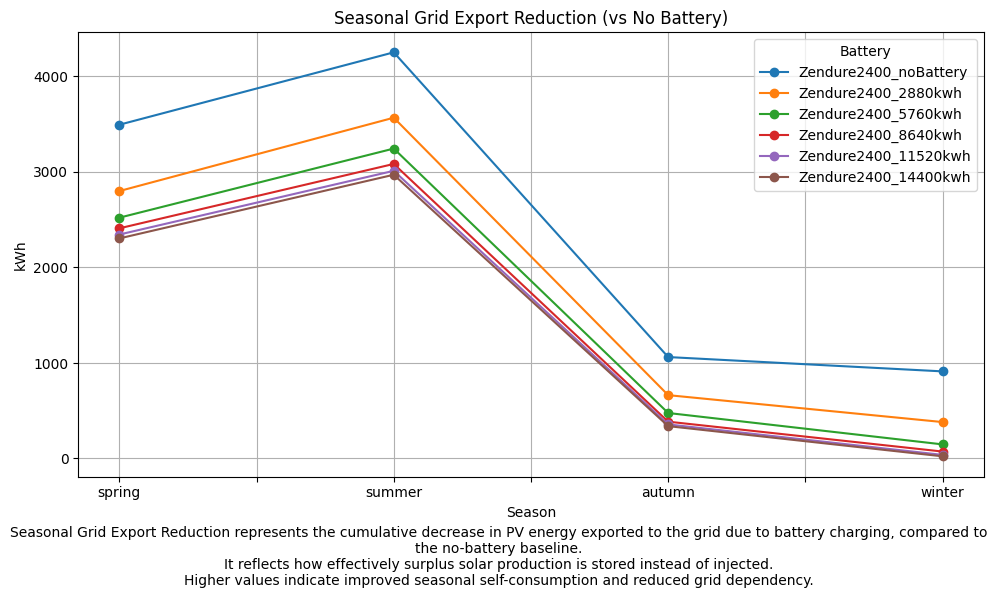

In [5]:
pivot = df_energy.pivot(
    index="season",
    columns="scenario",
    values="grid_injected_with_kwh"
)

pivot = pivot[scenario_order]

pivot.plot(marker="o")
plt.title("Seasonal Grid Export Reduction (vs No Battery)")
plt.xlabel("Season")
plt.ylabel("kWh")
plt.legend(title="Battery")
plt.tight_layout(rect=[0, 0.10, 1, 1])
plt.figtext(
    0.5, 0.02,
    "Seasonal Grid Export Reduction represents the cumulative decrease in PV energy "
    "exported to the grid due to battery charging, compared to the no-battery baseline.\n"
    "It reflects how effectively surplus solar production is stored instead of injected.\n"
    "Higher values indicate improved seasonal self-consumption and reduced grid dependency.",
    ha="center",
    fontsize=10,
    wrap=True
)
export_current_figure(SEASON_FIG_DIR)
plt.show()


Graph – Seasonal Battery Charged / Dicharged Energy

Saved figure: out/season/04_seasonal_battery_energy_flow_charge_vs_discharge.png


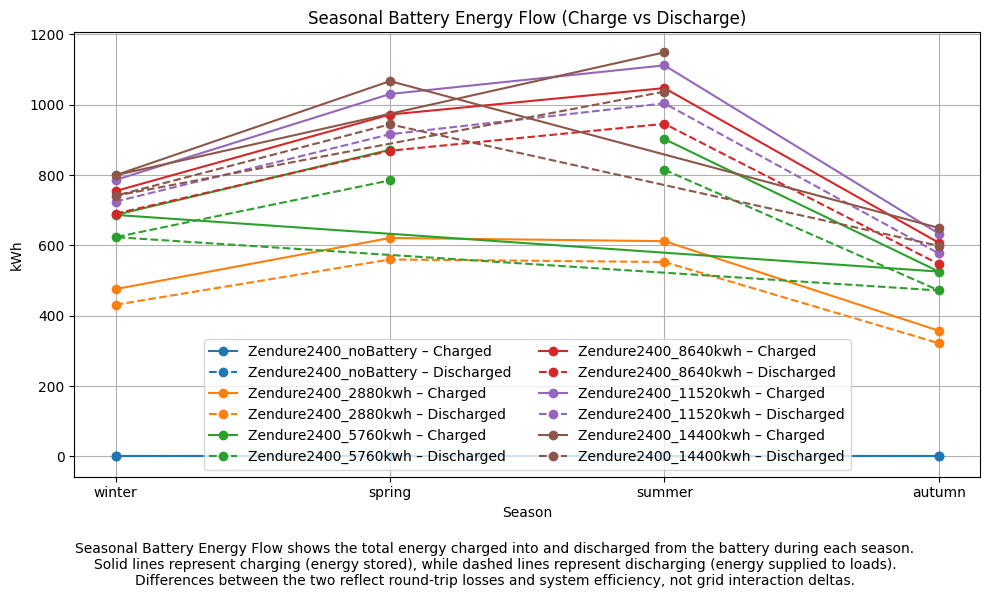

In [6]:
plt.figure(figsize=(10, 6))

# get a stable color cycle (matplotlib default)
color_cycle = plt.rcParams["axes.prop_cycle"].by_key()["color"]

for i, scenario in enumerate(scenario_order):
    subset = df_energy[df_energy["scenario"] == scenario]
    color = color_cycle[i % len(color_cycle)]

    # Charged (solid)
    plt.plot(
        subset["season"],
        subset["battery_charged_kwh"],
        marker="o",
        linestyle="-",
        color=color,
        label=f"{scenario} – Charged"
    )

    # Discharged (dashed)
    plt.plot(
        subset["season"],
        subset["battery_discharged_kwh"],
        marker="o",
        linestyle="--",
        color=color,
        label=f"{scenario} – Discharged"
    )

plt.title("Seasonal Battery Energy Flow (Charge vs Discharge)")
plt.xlabel("Season")
plt.ylabel("kWh")
plt.legend(ncol=2)
plt.grid(True)
plt.tight_layout(rect=[0, 0.10, 1, 1])
plt.figtext(
    0.5, 0.02,
    "Seasonal Battery Energy Flow shows the total energy charged into and discharged "
    "from the battery during each season.\n"
    "Solid lines represent charging (energy stored), while dashed lines represent "
    "discharging (energy supplied to loads).\n"
    "Differences between the two reflect round-trip losses and system efficiency, "
    "not grid interaction deltas.",
    ha="center",
    fontsize=10,
    wrap=True
)
export_current_figure(SEASON_FIG_DIR)
plt.show()



Seasonal Battery Throughput

Saved figure: out/season/05_seasonal_battery_energy_throughput_total_cycled_energy.png


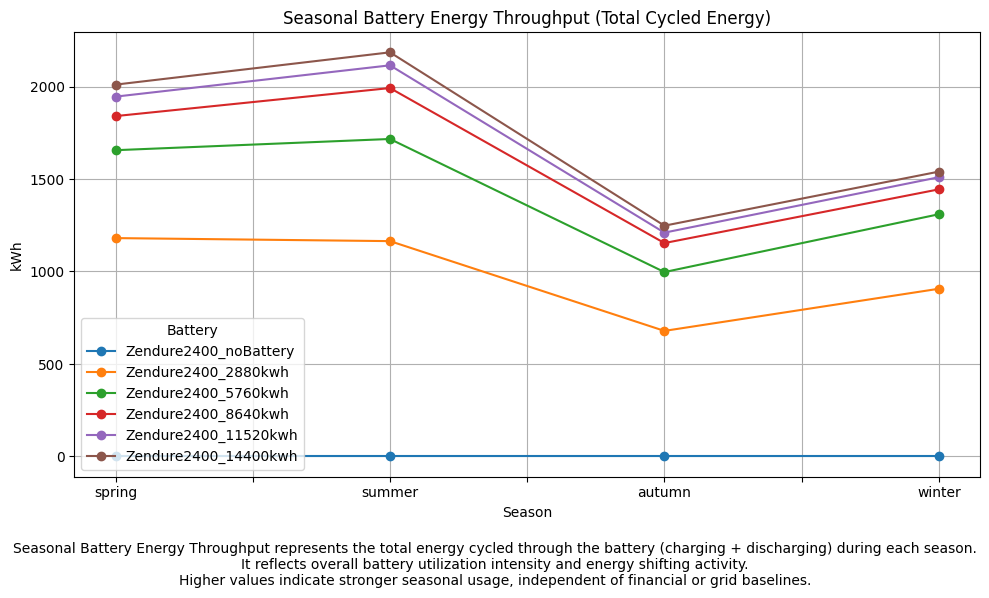

In [7]:
df_energy["battery_throughput_kwh"] = (
    df_energy["battery_charged_kwh"] +
    df_energy["battery_discharged_kwh"]
)

pivot = df_energy.pivot(
    index="season",
    columns="scenario",
    values="battery_throughput_kwh"
)

pivot = pivot[scenario_order]

pivot.plot(marker="o")
plt.title("Seasonal Battery Energy Throughput (Total Cycled Energy)")
plt.xlabel("Season")
plt.ylabel("kWh")
plt.legend(title="Battery")
plt.tight_layout(rect=[0, 0.10, 1, 1])
plt.figtext(
    0.5, 0.02,
    "Seasonal Battery Energy Throughput represents the total energy cycled through the battery "
    "(charging + discharging) during each season.\n"
    "It reflects overall battery utilization intensity and energy shifting activity.\n"
    "Higher values indicate stronger seasonal usage, independent of financial or grid baselines.",
    ha="center",
    fontsize=10,
    wrap=True
)
export_current_figure(SEASON_FIG_DIR)
plt.show()


Seasonal Battery FULL share

Saved figure: out/season/06_seasonal_energy_saturation_battery_full_soc_100.png


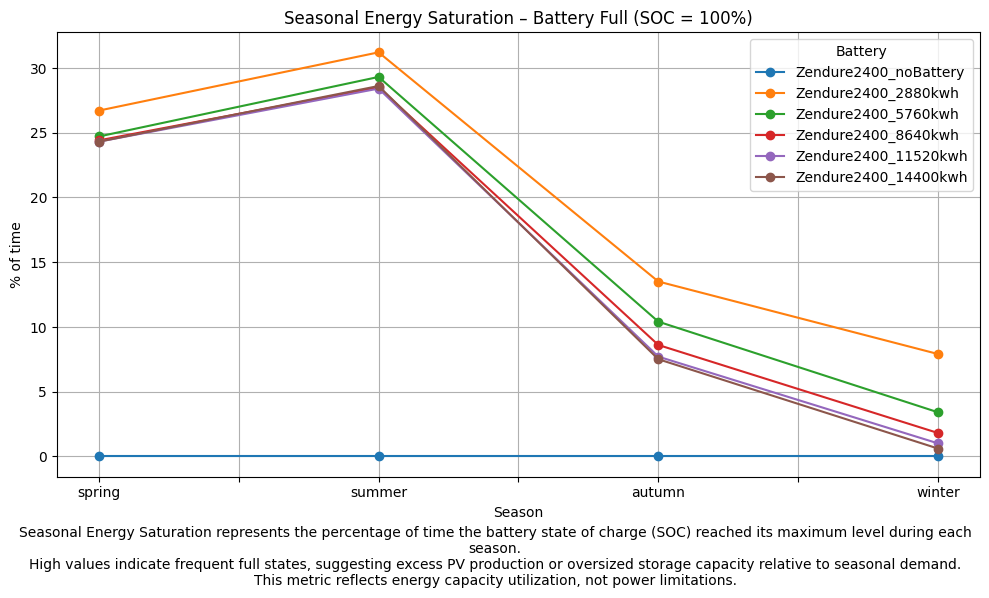

In [8]:
pivot = df_energy.pivot(
    index="season",
    columns="scenario",
    values="avg_full_pct"
)

pivot = pivot[scenario_order]

pivot.plot(marker="o")
plt.title("Seasonal Energy Saturation – Battery Full (SOC = 100%)")
plt.xlabel("Season")
plt.ylabel("% of time")
plt.legend(title="Battery")
plt.tight_layout(rect=[0, 0.10, 1, 1])
plt.figtext(
    0.5, 0.02,
    "Seasonal Energy Saturation represents the percentage of time the battery "
    "state of charge (SOC) reached its maximum level during each season.\n"
    "High values indicate frequent full states, suggesting excess PV production "
    "or oversized storage capacity relative to seasonal demand.\n"
    "This metric reflects energy capacity utilization, not power limitations.",
    ha="center",
    fontsize=10,
    wrap=True
)
export_current_figure(SEASON_FIG_DIR)
plt.show()


Seasonal Battery EMPTY share

Saved figure: out/season/07_seasonal_energy_limitation_battery_empty_soc_0.png


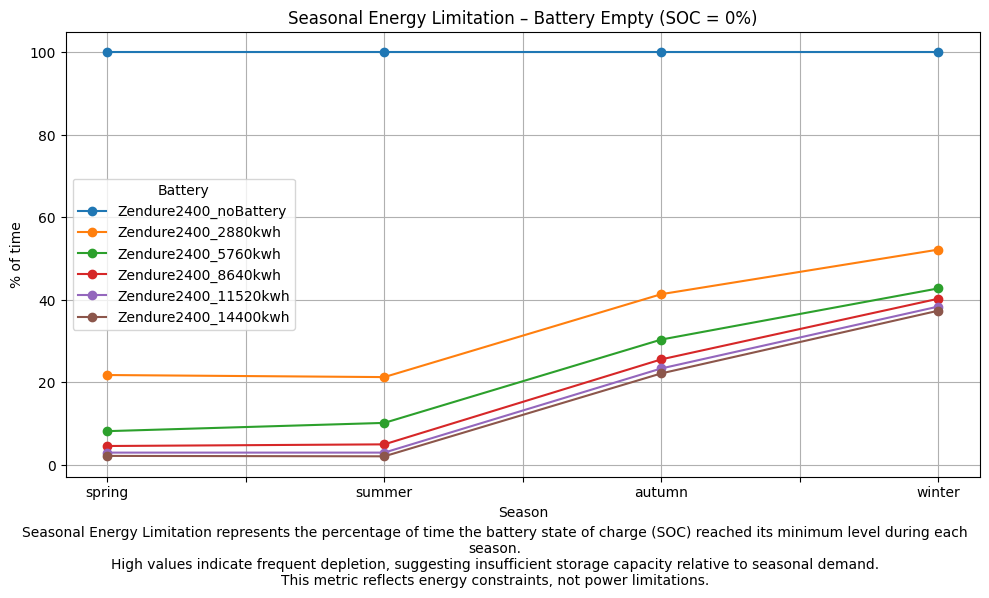

In [9]:
pivot = df_energy.pivot(
    index="season",
    columns="scenario",
    values="avg_empty_pct"
)

pivot = pivot[scenario_order]

pivot.plot(marker="o")
plt.title("Seasonal Energy Limitation – Battery Empty (SOC = 0%)")
plt.xlabel("Season")
plt.ylabel("% of time")
plt.legend(title="Battery")
plt.tight_layout(rect=[0, 0.10, 1, 1])
plt.figtext(
    0.5, 0.02,
    "Seasonal Energy Limitation represents the percentage of time the battery "
    "state of charge (SOC) reached its minimum level during each season.\n"
    "High values indicate frequent depletion, suggesting insufficient storage "
    "capacity relative to seasonal demand.\n"
    "This metric reflects energy constraints, not power limitations.",
    ha="center",
    fontsize=10,
    wrap=True
)
export_current_figure(SEASON_FIG_DIR)
plt.show()


Graph – Seasonal Energy Undersize Days

Saved figure: out/season/08_seasonal_structural_energy_undersizing_daily_level.png


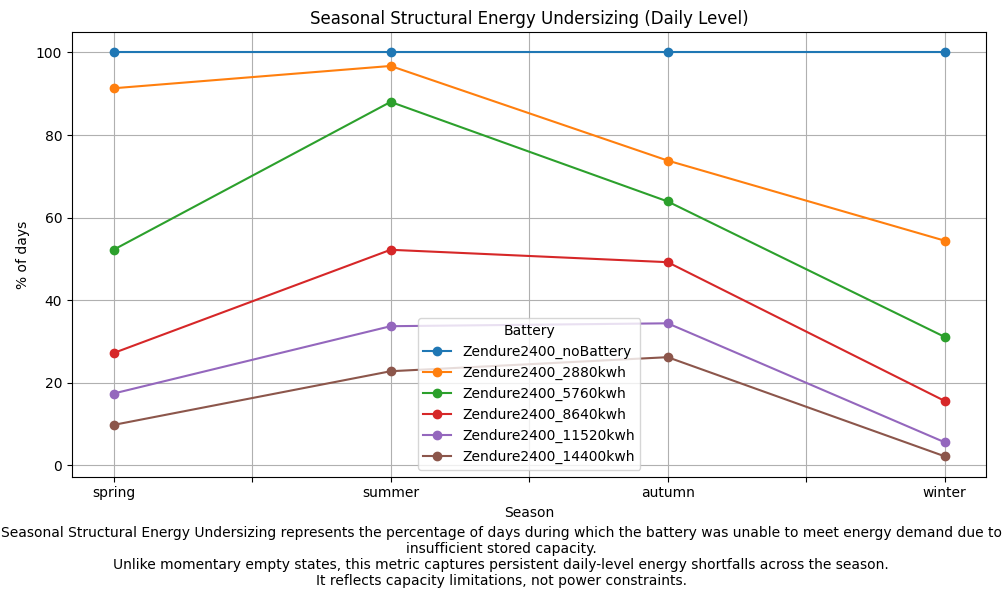

In [10]:
pivot = df_energy.pivot(
    index="season",
    columns="scenario",
    values="energy_undersize_pct"
)

pivot = pivot[scenario_order]

pivot.plot(marker="o")
plt.title("Seasonal Structural Energy Undersizing (Daily Level)")
plt.xlabel("Season")
plt.ylabel("% of days")
plt.legend(title="Battery")
plt.tight_layout(rect=[0, 0.10, 1, 1])
plt.figtext(
    0.5, 0.02,
    "Seasonal Structural Energy Undersizing represents the percentage of days "
    "during which the battery was unable to meet energy demand due to insufficient "
    "stored capacity.\n"
    "Unlike momentary empty states, this metric captures persistent daily-level "
    "energy shortfalls across the season.\n"
    "It reflects capacity limitations, not power constraints.",
    ha="center",
    fontsize=10,
    wrap=True
)
export_current_figure(SEASON_FIG_DIR)
plt.show()


Graph – Seasonal Evening Undersize Days

Saved figure: out/season/09_seasonal_structural_evening_energy_undersizing_peak_period.png


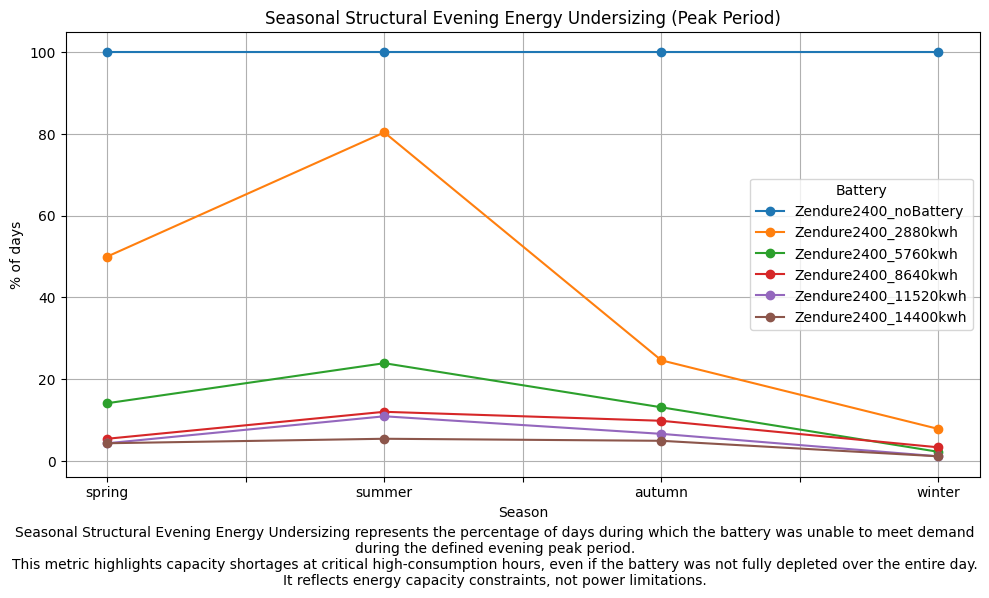

In [11]:
pivot = df_energy.pivot(
    index="season",
    columns="scenario",
    values="evening_undersize_pct"
)

pivot = pivot[scenario_order]

pivot.plot(marker="o")
plt.title("Seasonal Structural Evening Energy Undersizing (Peak Period)")
plt.xlabel("Season")
plt.ylabel("% of days")
plt.legend(title="Battery")
plt.tight_layout(rect=[0, 0.10, 1, 1])
plt.figtext(
    0.5, 0.02,
    "Seasonal Structural Evening Energy Undersizing represents the percentage of days "
    "during which the battery was unable to meet demand during the defined evening peak period.\n"
    "This metric highlights capacity shortages at critical high-consumption hours, "
    "even if the battery was not fully depleted over the entire day.\n"
    "It reflects energy capacity constraints, not power limitations.",
    ha="center",
    fontsize=10,
    wrap=True
)
export_current_figure(SEASON_FIG_DIR)
plt.show()


Plot – Seasonal Power Saturation

Saved figure: out/season/10_seasonal_power_saturation_at_maximum_limit.png


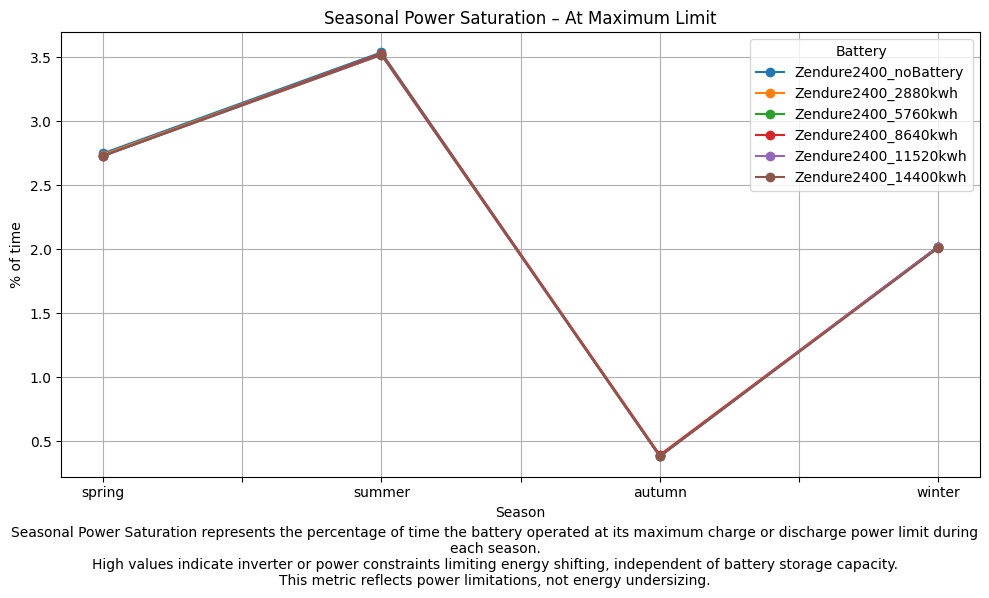

In [12]:
pivot = df_energy.pivot(
    index="season",
    columns="scenario",
    values="power_at_max_pct"
)

pivot = pivot[scenario_order]

pivot.plot(marker="o")
plt.title("Seasonal Power Saturation – At Maximum Limit")
plt.xlabel("Season")
plt.ylabel("% of time")
plt.legend(title="Battery")
plt.tight_layout(rect=[0, 0.10, 1, 1])
plt.figtext(
    0.5, 0.02,
    "Seasonal Power Saturation represents the percentage of time the battery "
    "operated at its maximum charge or discharge power limit during each season.\n"
    "High values indicate inverter or power constraints limiting energy shifting, "
    "independent of battery storage capacity.\n"
    "This metric reflects power limitations, not energy undersizing.",
    ha="center",
    fontsize=10,
    wrap=True
)
export_current_figure(SEASON_FIG_DIR)
plt.show()


Saved figure: out/season/11_seasonal_power_saturation_active_charge_discharge.png


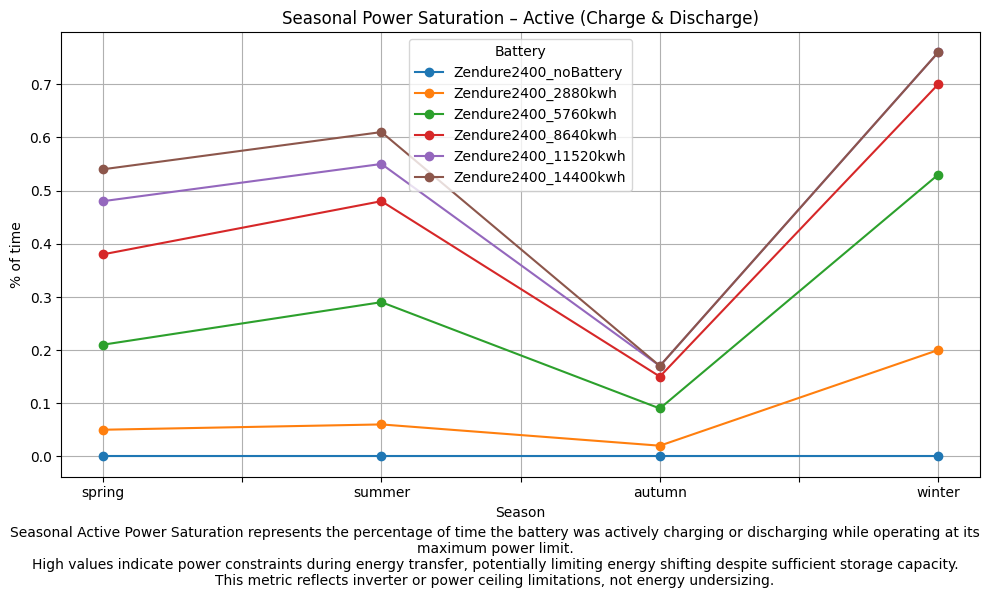

In [13]:
pivot = df_energy.pivot(
    index="season",
    columns="scenario",
    values="active_power_at_max_pct"
)

pivot = pivot.reindex(SEASON_ORDER)
pivot = pivot[scenario_order]

pivot.plot(marker="o")
plt.title("Seasonal Power Saturation – Active (Charge & Discharge)")
plt.xlabel("Season")
plt.ylabel("% of time")
plt.legend(title="Battery")
plt.tight_layout(rect=[0, 0.10, 1, 1])
plt.figtext(
    0.5, 0.02,
    "Seasonal Active Power Saturation represents the percentage of time the battery "
    "was actively charging or discharging while operating at its maximum power limit.\n"
    "High values indicate power constraints during energy transfer, potentially limiting "
    "energy shifting despite sufficient storage capacity.\n"
    "This metric reflects inverter or power ceiling limitations, not energy undersizing.",
    ha="center",
    fontsize=10,
    wrap=True
)
export_current_figure(SEASON_FIG_DIR)
plt.show()


Saved figure: out/season/12_seasonal_power_saturation_idle_missed_opportunities.png


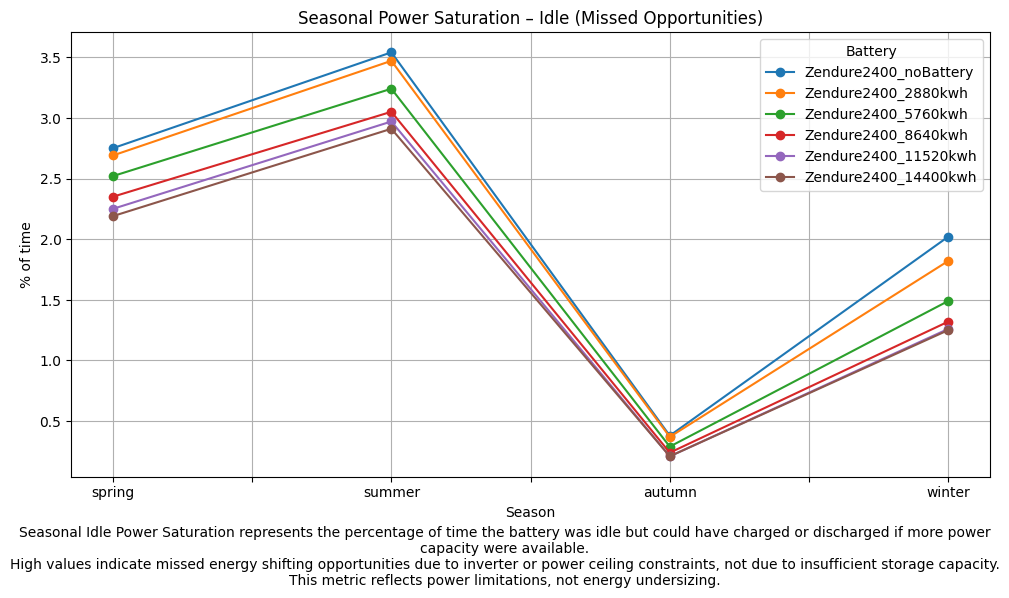

In [14]:
pivot = df_energy.pivot(
    index="season",
    columns="scenario",
    values="idle_power_limited_pct"
)

pivot = pivot.reindex(SEASON_ORDER)
pivot = pivot[scenario_order]

pivot.plot(marker="o")
plt.title("Seasonal Power Saturation – Idle (Missed Opportunities)")
plt.xlabel("Season")
plt.ylabel("% of time")
plt.legend(title="Battery")
plt.tight_layout(rect=[0, 0.10, 1, 1])
plt.figtext(
    0.5, 0.02,
    "Seasonal Idle Power Saturation represents the percentage of time the battery "
    "was idle but could have charged or discharged if more power capacity were available.\n"
    "High values indicate missed energy shifting opportunities due to inverter or "
    "power ceiling constraints, not due to insufficient storage capacity.\n"
    "This metric reflects power limitations, not energy undersizing.",
    ha="center",
    fontsize=10,
    wrap=True
)
export_current_figure(SEASON_FIG_DIR)
plt.show()


Saved figure: out/season/13_seasonal_power_state_distribution_active_idle_modes.png


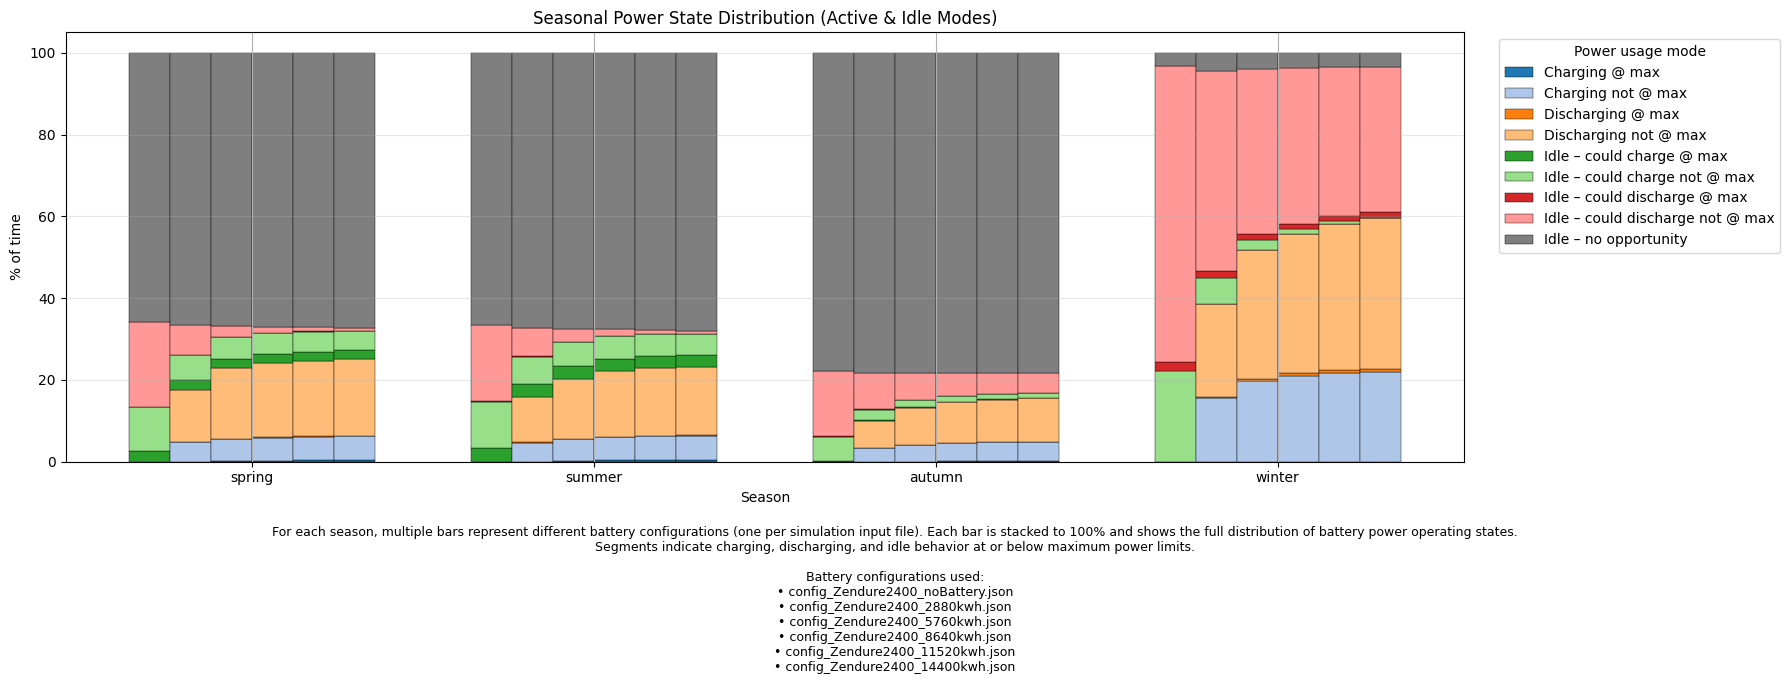

In [15]:
STACK_COMPONENTS = [
    # Charging
    ("charging_at_max_pct", "Charging @ max", "#1f77b4"),
    ("charging_not_at_max_pct", "Charging not @ max", "#aec7e8"),

    # Discharging
    ("discharging_at_max_pct", "Discharging @ max", "#ff7f0e"),
    ("discharging_not_at_max_pct", "Discharging not @ max", "#ffbb78"),

    # Idle – could charge
    ("idle_could_charge_at_max_pct", "Idle – could charge @ max", "#2ca02c"),
    ("idle_could_charge_not_at_max_pct", "Idle – could charge not @ max", "#98df8a"),

    # Idle – could discharge
    ("idle_could_discharge_at_max_pct", "Idle – could discharge @ max", "#d62728"),
    ("idle_could_discharge_not_at_max_pct", "Idle – could discharge not @ max", "#ff9896"),

    # Idle – no opportunity
    ("idle_no_opportunity_pct", "Idle – no opportunity", "#7f7f7f"),
]

import numpy as np

seasons = SEASON_ORDER
n_seasons = len(seasons)
n_batteries = len(scenario_order)

x = np.arange(n_seasons)
bar_width = 0.12

plt.figure(figsize=(18, 7))

for b_idx, scenario in enumerate(scenario_order):
    subset = (
        df_energy[df_energy["scenario"] == scenario]
        .set_index("season")
        .reindex(seasons)
    )

    bottom = np.zeros(n_seasons)
    x_pos = x + b_idx * bar_width

    for col, label, color in STACK_COMPONENTS:
        values = subset[col].values
        plt.bar(
            x_pos,
            values,
            width=bar_width,
            bottom=bottom,
            color=color,
            edgecolor="black",
            linewidth=0.3,
            label=label if b_idx == 0 else None
        )
        bottom += values

# X-axis ticks centered on battery groups
plt.xticks(
    x + bar_width * (n_batteries - 1) / 2,
    seasons
)

plt.xlabel("Season")
plt.ylabel("% of time")
plt.title("Seasonal Power State Distribution (Active & Idle Modes)")
plt.legend(
    title="Power usage mode",
    bbox_to_anchor=(1.02, 1),
    loc="upper left"
)

plt.grid(axis="y", alpha=0.3)
plt.tight_layout(rect=[0, 0.25, 1, 1])
config_list = "\n".join(
    f"• {pathlib.Path(f).name}" for f in FILES
)
plt.figtext(
    0.5, 0.03,
    "For each season, multiple bars represent different battery configurations "
    "(one per simulation input file). Each bar is stacked to 100% and shows the "
    "full distribution of battery power operating states.\n"
    "Segments indicate charging, discharging, and idle behavior at or below "
    "maximum power limits.\n\n"
    f"Battery configurations used:\n{config_list}",
    ha="center",
    va="bottom",
    fontsize=9,
    wrap=True
)

export_current_figure(SEASON_FIG_DIR)
plt.show()

In [16]:
SAMPLE_DURATION_H = 1  # 1 hour per sample

SEASON_ACTIVITY_ROWS = []

for file in FILES:
    scenario = pathlib.Path(file).stem.replace("config_", "")
    data = load_json(file)

    seasons = data.get("seasons", {})
    if not seasons:
        continue

    for season, values in seasons.items():

        pu = values.get("power_usage", {})

        charging_samples = (
            pu.get("charging", {}).get("at_max", {}).get("sample_count", 0) +
            pu.get("charging", {}).get("not_at_max", {}).get("sample_count", 0)
        )

        discharging_samples = (
            pu.get("discharging", {}).get("at_max", {}).get("sample_count", 0) +
            pu.get("discharging", {}).get("not_at_max", {}).get("sample_count", 0)
        )

        SEASON_ACTIVITY_ROWS.append({
            "season": season.lower(),
            "scenario": scenario,
            "charging_hours": charging_samples * SAMPLE_DURATION_H,
            "discharging_hours": discharging_samples * SAMPLE_DURATION_H
        })

df_season_activity = pd.DataFrame(SEASON_ACTIVITY_ROWS)

df_season_activity["season"] = pd.Categorical(
    df_season_activity["season"],
    categories=SEASON_ORDER,
    ordered=True
)

df_season_activity = df_season_activity.sort_values("season")


Saved figure: out/season/14_seasonal_battery_activity_duration_charging_vs_discharging.png


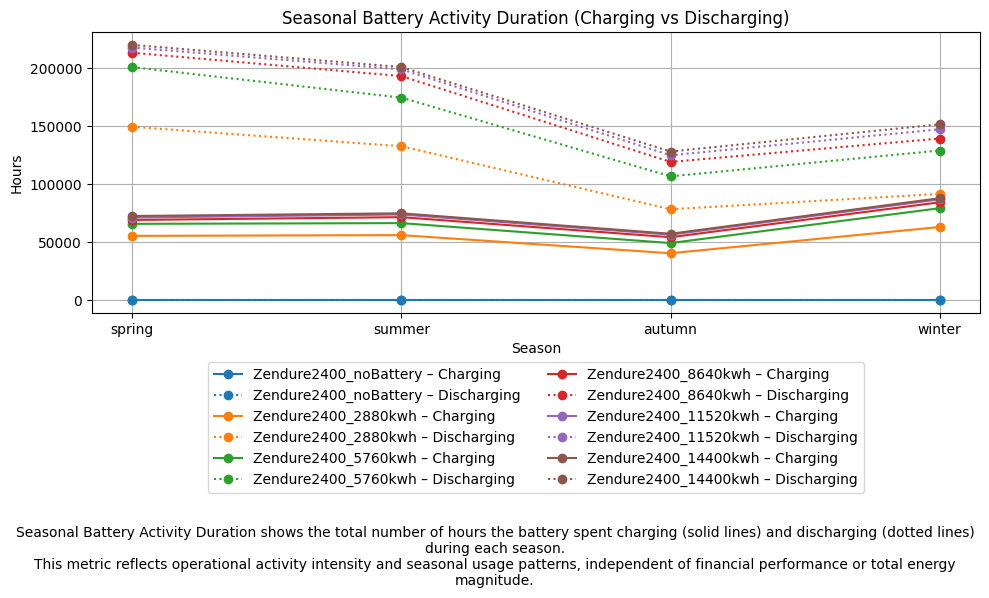

In [17]:
plt.figure(figsize=(10, 6))

color_cycle = plt.rcParams["axes.prop_cycle"].by_key()["color"]

for i, scenario in enumerate(scenario_order):
    subset = (
        df_season_activity[df_season_activity["scenario"] == scenario]
        .sort_values("season")
    )

    color = color_cycle[i % len(color_cycle)]

    # Charging – solid
    plt.plot(
        subset["season"],
        subset["charging_hours"],
        marker="o",
        linestyle="-",
        color=color,
        label=f"{scenario} – Charging"
    )

    # Discharging – dotted
    plt.plot(
        subset["season"],
        subset["discharging_hours"],
        marker="o",
        linestyle=":",
        color=color,
        label=f"{scenario} – Discharging"
    )

plt.title("Seasonal Battery Activity Duration (Charging vs Discharging)")
plt.xlabel("Season")
plt.ylabel("Hours")

plt.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, -0.15),
    ncol=2
)

plt.tight_layout(rect=[0, 0.10, 1, 1])
plt.grid(True)

plt.figtext(
    0.5, 0.02,
    "Seasonal Battery Activity Duration shows the total number of hours the battery "
    "spent charging (solid lines) and discharging (dotted lines) during each season.\n"
    "This metric reflects operational activity intensity and seasonal usage patterns, "
    "independent of financial performance or total energy magnitude.",
    ha="center",
    fontsize=10,
    wrap=True
)

export_current_figure(SEASON_FIG_DIR)
plt.show()
